In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import utils
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_rows=100
pd.options.display.max_columns = 150

In [3]:
# Load data
movies = pd.read_csv("../data/Movie Data.csv")

In [4]:
movies.head()

,Movie,Budget (thousands of $),Domestic Box Office Revenue (thousands of $),International Box Office Revenue (thousands of $),MPAA Rating,Running time,Franchise,Original source,Genre,Production method,Type,Production companies,Production country,Languages,Distributor,Release year
0,10 Questions for the Dalai Lama,NaN,224.5,260.0,Not Rated,NaN,NaN,Real Life Events,Documentary,Live Action,Factual,NaN,United States,English,Monterey Media,2007
1,10th & Wolf,8000.0,54.7,89.1,Not Rated,NaN,NaN,Real Life Events,Drama,Live Action,Dramatization,NaN,United States,English,ThinkFilm,2006
2,2006 Academy Award Nominated Short Films,NaN,335.1,NaN,Not Rated,NaN,Academy Award Short Film Nominations,Compilation,Thriller,Multiple Production Methods,Multiple Creative Types,NaN,United States,English,Magnolia Pictures,2007
3,24 Hour Party People,NaN,1169.0,2435.9,"R for strong language, drug use and sexuality",NaN,NaN,Real Life Events,Drama,Live Action,Dramatization,NaN,United States,English,MGM,2002
4,39 Pounds of Love,NaN,28.1,2.1,Not Rated,NaN,NaN,Real Life Events,Documentary,Live Action,Factual,NaN,United States,English,Balcony Releasing,2005


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5691 entries, 0 to 5690
Data columns (total 16 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Movie                                              5691 non-null   object 
 1   Budget (thousands of $)                            3525 non-null   float64
 2   Domestic Box Office Revenue (thousands of $)       5691 non-null   float64
 3   International Box Office Revenue (thousands of $)  4432 non-null   float64
 4   MPAA Rating                                        5685 non-null   object 
 5   Running time                                       4656 non-null   object 
 6   Franchise                                          940 non-null    object 
 7   Original source                                    5521 non-null   object 
 8   Genre                                              5680 non-null   object 
 9   Producti

In [6]:
movie_cast.head()

,Movie,Type,Name,Role
0,"10,000 B.C.",Actors,Steven Strait,D'Leh
1,"10,000 B.C.",Actors,Camilla Belle,Evolet
2,"10,000 B.C.",Actors,Cliff Curtis,Tic-Tic
3,"10,000 B.C.",Actors,Reece Ritchie,Moha
4,"10,000 B.C.",Actors,Marco Khan,One Eye


In [7]:
# Transform column names to lower case and replace whitespaces with '_'
movies.columns = [col_name.replace(" ", "_").lower() for col_name in movies.columns]
movie_cast.columns = [col_name.replace(" ", "_").lower() for col_name in movie_cast.columns]


## Data preparation

In [8]:
movies.isna().sum()

movie                                                   0
budget_(thousands_of_$)                              2166
domestic_box_office_revenue_(thousands_of_$)            0
international_box_office_revenue_(thousands_of_$)    1259
mpaa_rating                                             6
running_time                                         1035
franchise                                            4751
original_source                                       170
genre                                                  11
production_method                                     105
type                                                  226
production_companies                                 1812
production_country                                      6
languages                                              30
distributor                                            58
release_year                                            0
dtype: int64

In [9]:
# Clean variables 
# change names of budget and revenue variables
movies.rename(columns={'budget_(thousands_of_$)': 'budget',
  'domestic_box_office_revenue_(thousands_of_$)': 'us_revenue',
  'international_box_office_revenue_(thousands_of_$)': 'international_revenue'}, inplace=True)

# Imputing zeros for missing data in 3 columns
movies['international_revenue'] = movies['international_revenue'].fillna(0)
movies['us_revenue'] = movies['us_revenue'].fillna(0)
movies['budget'] = movies['budget'].fillna(0)

# Change the scale of dollar variables, our target will be total revenue in millions
movies['total_revenue'] = (movies['us_revenue'] + movies['international_revenue']) / 1000
movies['budget'] = movies['budget'] / 1000

# Filter movies without budget information and too small budgets
movies = movies[(movies.total_revenue > 0.1) & (movies.budget > 1)].reset_index(drop=True)

In [10]:
movies['mpaa_rating_clean'] = ""
movies.loc[movies.mpaa_rating.str.contains("Not Rated"), 'mpaa_rating_clean'] = "Not Rated"
movies.loc[movies.mpaa_rating.str.contains("PG-13"), 'mpaa_rating_clean'] = "PG-13"
movies.loc[movies.mpaa_rating.str.contains("R([ (]|$)"), 'mpaa_rating_clean'] = "R"
movies.loc[movies.mpaa_rating.str.contains("G([ (]|$)"), 'mpaa_rating_clean'] = "G"
movies.loc[movies.mpaa_rating_clean=="", 'mpaa_rating_clean'] = "G"

C:\Users\nimblepants\anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [11]:
pd.options.display.max_rows = 100

In [12]:
print(utils.get_groups(movies, 'languages'))

                  languages  count  mean_revenue  mean_budget
0                   English   3023    139.714162    45.776798
1          English, Spanish     39     51.880618    24.730769
2           English, French     23     74.450972    27.534783
3                    French     21     58.303633    19.886214
4         English, Japanese     10    145.171540    63.060000
..                      ...    ...           ...          ...
148  Dutch, English, German      1      9.662300     5.800000
149                   Dutch      1     27.238300    22.000000
150         Danish, Swedish      1     15.867300     5.500000
151          Danish, German      1      1.635300     9.000000
152                 Turkish      1      5.552600     1.400000

[153 rows x 4 columns]


In [13]:
# replacing low counts with others
movies = utils.create_others(movies, 'languages', 9)
print(utils.get_groups(movies, 'languages2'))

          languages2  count  mean_revenue  mean_budget
0            English   3023    139.714162    45.776798
1              Other    234    130.060316    40.119615
2   English, Spanish     39     51.880618    24.730769
3    English, French     23     74.450972    27.534783
4             French     21     58.303633    19.886214
5  English, Japanese     10    145.171540    63.060000
6            Spanish     10     32.324450     4.940000
7              Hindi      9     70.691992     8.150000
8           Japanese      9    116.358789    18.722222


In [14]:
print(utils.get_groups(movies, 'mpaa_rating_clean'))

  mpaa_rating_clean  count  mean_revenue  mean_budget
0                 R   1374     75.021279    27.910105
1             PG-13   1353    173.104413    55.932738
2                 G    602    202.483626    60.128450
3         Not Rated     49     41.303764     9.912347


In [15]:
utils.get_groups(movies, 'franchise')

,franchise,count,mean_revenue,mean_budget
0,Star Wars,10,926.636632,163.250000
1,Madea,9,62.367573,18.000000
2,Fast and the Furious,9,659.246558,134.333333
3,Harry Potter,8,972.171779,144.375000
4,Saw,8,122.995304,9.375000
...,...,...,...,...
416,El Mariachi,1,97.413600,29.000000
417,Power Rangers,1,146.131550,120.000000
418,Dungeons & Dragons,1,33.771900,35.000000
419,Dumbo,1,355.766307,170.000000


In [16]:
# creating a dummy variable for movies belonging to a franchise
movies.loc[:, 'is_franchise'] = (movies.franchise==np.nan).astype(int)

In [17]:
utils.get_groups(movies, 'original_source')

,original_source,count,mean_revenue,mean_budget
0,Original Screenplay,1718,110.915876,36.223210
1,Fiction Book/Short Story,637,155.567273,51.120130
2,Real Life Events,272,61.873325,25.786213
3,Remake,170,141.410397,50.843311
4,Comic/Graphic Novel,131,427.006358,119.092366
5,Factual Book/Article,112,113.509500,37.062946
6,TV,110,195.597228,64.254545
7,Play,43,55.130197,16.483721
8,Game,33,174.205381,70.560606
9,Folk Tale/Legend/Fairytale,33,277.996315,96.487879


In [18]:
movies = utils.create_others(movies, 'original_source', 100)
utils.get_groups(movies, 'original_source2')

,original_source2,count,mean_revenue,mean_budget
0,Original Screenplay,1718,110.915876,36.223210
1,Fiction Book/Short Story,637,155.567273,51.120130
2,Real Life Events,272,61.873325,25.786213
3,Other,228,177.731598,58.930482
4,Remake,170,141.410397,50.843311
5,Comic/Graphic Novel,131,427.006358,119.092366
6,Factual Book/Article,112,113.509500,37.062946
7,TV,110,195.597228,64.254545


In [19]:
utils.get_groups(movies, 'genre')

,genre,count,mean_revenue,mean_budget
0,Drama,863,67.090426,25.753023
1,Comedy,607,73.893418,28.392051
2,Adventure,497,302.241105,88.215493
3,Action,441,264.217688,85.203204
4,Thriller,392,96.171122,36.659608
5,Horror,246,88.642781,20.631707
6,Romantic Comedy,165,88.315432,29.432242
7,Musical,51,206.045693,50.526020
8,Dark Comedy,47,68.529255,25.547872
9,Documentary,32,46.433249,11.378125


In [20]:
movies = utils.create_others(movies, 'genre', 52)
utils.get_groups(movies, 'genre2')

,genre2,count,mean_revenue,mean_budget
0,Drama,863,67.090426,25.753023
1,Comedy,607,73.893418,28.392051
2,Adventure,497,302.241105,88.215493
3,Action,441,264.217688,85.203204
4,Thriller,392,96.171122,36.659608
5,Horror,246,88.642781,20.631707
6,Other,167,105.659361,33.111838
7,Romantic Comedy,165,88.315432,29.432242


In [21]:
movies = utils.create_others(movies, 'production_method', 10)
utils.get_groups(movies, 'production_method2')

,production_method2,count,mean_revenue,mean_budget
0,Live Action,3003,104.108091,37.872631
1,Digital Animation,164,364.246378,93.617683
2,Animation/Live Action,146,563.788444,133.080137
3,Hand Animation,41,122.995629,38.043902
4,Stop-Motion Animation,14,99.405574,40.142857
5,Other,10,8.792087,7.220000


In [22]:
movies = utils.create_others(movies, 'type', 10)
utils.get_groups(movies, 'type2')

,type2,count,mean_revenue,mean_budget
0,Contemporary Fiction,1736,85.733127,30.014462
1,Historical Fiction,346,103.983994,42.162099
2,Dramatization,341,76.942152,31.200880
3,Science Fiction,286,246.597739,78.404712
4,Kids Fiction,265,273.062766,75.801132
5,Fantasy,248,229.212117,71.977931
6,Super Hero,85,566.172573,144.585213
7,Factual,43,46.663972,11.141860
8,Other,28,10.560053,8.764286


In [23]:
movies = utils.create_others(movies, 'production_companies', 10)
utils.get_groups(movies, 'production_companies2')

,production_companies2,count,mean_revenue,mean_budget
0,Other,3256,129.239589,43.006821
1,Columbia Pictures,16,134.930962,60.500000
2,Walt Disney Pictures,15,259.856820,90.653333
3,Marvel Studios,14,1152.006473,211.642857
4,Working Title Films,14,104.976488,28.071429
5,DreamWorks Animation,12,509.445355,135.416667
6,Universal Pictures,11,178.512113,71.454545
7,Lakeshore Entertainment,10,61.062390,25.700000
8,Revolution Studios,10,79.488850,42.300000
9,Walt Disney Animation Studios,10,563.033191,133.000000


In [24]:
movies = utils.create_others(movies, 'production_country', 20)
utils.get_groups(movies, 'production_country2')

,production_country2,count,mean_revenue,mean_budget
0,United States,2652,145.445511,46.794578
1,Other,380,85.581975,32.434086
2,"United Kingdom, United States",111,228.831049,62.022483
3,United Kingdom,84,50.948347,22.018810
4,France,38,68.201025,26.480539
5,"Canada, United States",37,54.530623,28.870270
6,"Germany, United States",33,78.078964,42.545455
7,"Australia, United States",23,154.933529,62.891304
8,"France, United States",20,126.831640,31.265000


In [25]:
movies = utils.create_others(movies, 'distributor', 100)
utils.get_groups(movies, 'distributor2')


,distributor2,count,mean_revenue,mean_budget
0,Other,1193,59.116730,22.826512
1,Warner Bros.,395,183.293110,63.126271
2,Sony Pictures,369,145.994756,51.291653
3,Universal,307,184.606132,54.571417
4,20th Century Fox,303,187.524241,56.307921
5,Paramount Pictures,254,187.202277,64.666142
6,Walt Disney,247,328.543858,88.783517
7,Lionsgate,210,83.930931,30.003647
8,Fox Searchlight,100,45.902984,11.447656


In [26]:
movies = utils.create_others(movies, 'languages', 10)
utils.get_groups(movies, 'languages2')

,languages2,count,mean_revenue,mean_budget
0,English,3023,139.714162,45.776798
1,Other,252,127.450678,38.213651
2,"English, Spanish",39,51.880618,24.730769
3,"English, French",23,74.450972,27.534783
4,French,21,58.303633,19.886214
5,"English, Japanese",10,145.171540,63.060000
6,Spanish,10,32.324450,4.940000


In [27]:
# Duration 
# transform to a numeric variable
movies.running_time.fillna('0', inplace=True)
movies.loc[:,'duration'] = movies['running_time'].str.replace(' minutes', '').astype(int)

# create a dummy variable for NA's
movies.loc[:,'na_duration'] = (movies['duration']==0).astype(int)

In [28]:
cols2encode = ['mpaa_rating_clean',                  
                'distributor2',
                'original_source2',             
                'genre2',                       
                'production_method2',           
                'type2',                        
                'production_companies2',        
                'production_country2',          
                'languages2']                   

In [29]:
# One hot encoding 
movies = utils.encode_category(movies, cols2encode)
movies.shape

(3378, 104)

In [30]:
categorical = movies.select_dtypes(include='object').columns
numeric = movies.select_dtypes(include=['int32','int64', 'float64']).columns
to_drop = [col for col in numeric if col.startswith('n_')]
numeric = [col for col in numeric if col not in to_drop]
numeric

['budget',
 'us_revenue',
 'international_revenue',
 'release_year',
 'total_revenue',
 'is_franchise',
 'duration',
 'na_duration',
 'mpaa_rating_clean_R',
 'mpaa_rating_clean_PG-13',
 'mpaa_rating_clean_NotRated',
 'mpaa_rating_clean_G',
 'distributor2_Other',
 'distributor2_WaltDisney',
 'distributor2_20thCenturyFox',
 'distributor2_ParamountPictures',
 'distributor2_Lionsgate',
 'distributor2_FoxSearchlight',
 'distributor2_SonyPictures',
 'distributor2_WarnerBros.',
 'distributor2_Universal',
 'original_source2_TV',
 'original_source2_Other',
 'original_source2_Remake',
 'original_source2_FactualBook/Article',
 'original_source2_Comic/GraphicNovel',
 'original_source2_FictionBook/ShortStory',
 'original_source2_OriginalScreenplay',
 'original_source2_RealLifeEvents',
 'genre2_Other',
 'genre2_Drama',
 'genre2_Thriller',
 'genre2_RomanticComedy',
 'genre2_Adventure',
 'genre2_Action',
 'genre2_Horror',
 'genre2_Comedy',
 'production_method2_Animation/LiveAction',
 'production_metho

In [31]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3378 entries, 0 to 3377
Columns: 104 entries, movie to languages2_Japanese
dtypes: float64(11), int32(3), int64(69), object(21)
memory usage: 2.6+ MB


In [32]:
movies[numeric].head()

,budget,us_revenue,international_revenue,release_year,total_revenue,is_franchise,duration,na_duration,mpaa_rating_clean_R,mpaa_rating_clean_PG-13,mpaa_rating_clean_NotRated,mpaa_rating_clean_G,distributor2_Other,distributor2_WaltDisney,distributor2_20thCenturyFox,distributor2_ParamountPictures,distributor2_Lionsgate,distributor2_FoxSearchlight,distributor2_SonyPictures,distributor2_WarnerBros.,distributor2_Universal,original_source2_TV,original_source2_Other,original_source2_Remake,original_source2_FactualBook/Article,original_source2_Comic/GraphicNovel,original_source2_FictionBook/ShortStory,original_source2_OriginalScreenplay,original_source2_RealLifeEvents,genre2_Other,genre2_Drama,genre2_Thriller,genre2_RomanticComedy,genre2_Adventure,genre2_Action,genre2_Horror,genre2_Comedy,production_method2_Animation/LiveAction,production_method2_Other,production_method2_HandAnimation,production_method2_LiveAction,production_method2_DigitalAnimation,production_method2_Stop-MotionAnimation,type2_Fantasy,type2_ScienceFiction,type2_Other,type2_HistoricalFiction,type2_Dramatization,type2_KidsFiction,type2_Factual,type2_ContemporaryFiction,type2_SuperHero,production_companies2_MarvelStudios,production_companies2_UniversalPictures,production_companies2_Other,production_companies2_LakeshoreEntertainment,production_companies2_ColumbiaPictures,production_companies2_WorkingTitleFilms,production_companies2_WaltDisneyPictures,production_companies2_WarnerBros.,production_companies2_DreamWorksAnimation,production_companies2_WaltDisneyAnimationStudios,production_companies2_RevolutionStudios,production_country2_Canada,production_country2_UnitedStates,production_country2_Other,production_country2_France,production_country2_UnitedKingdom,production_country2_Germany,production_country2_Australia,languages2_Other,languages2_English,languages2_French,languages2_Spanish,languages2_Japanese
0,8.0,54.7,89.1,2006,0.1438,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,20.0,15543.9,1886.7,2003,17.4306,0,101,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,25.0,10719.4,1500.0,2002,12.2194,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,6.8,927.1,0.0,2000,0.9271,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,55.0,7221.5,2300.0,2006,9.5215,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [33]:
movies[numeric].corr()

,budget,us_revenue,international_revenue,release_year,total_revenue,is_franchise,duration,na_duration,mpaa_rating_clean_R,mpaa_rating_clean_PG-13,mpaa_rating_clean_NotRated,mpaa_rating_clean_G,distributor2_Other,distributor2_WaltDisney,distributor2_20thCenturyFox,distributor2_ParamountPictures,distributor2_Lionsgate,distributor2_FoxSearchlight,distributor2_SonyPictures,distributor2_WarnerBros.,distributor2_Universal,original_source2_TV,original_source2_Other,original_source2_Remake,original_source2_FactualBook/Article,original_source2_Comic/GraphicNovel,original_source2_FictionBook/ShortStory,original_source2_OriginalScreenplay,original_source2_RealLifeEvents,genre2_Other,genre2_Drama,genre2_Thriller,genre2_RomanticComedy,genre2_Adventure,genre2_Action,genre2_Horror,genre2_Comedy,production_method2_Animation/LiveAction,production_method2_Other,production_method2_HandAnimation,production_method2_LiveAction,production_method2_DigitalAnimation,production_method2_Stop-MotionAnimation,type2_Fantasy,type2_ScienceFiction,type2_Other,type2_HistoricalFiction,type2_Dramatization,type2_KidsFiction,type2_Factual,type2_ContemporaryFiction,type2_SuperHero,production_companies2_MarvelStudios,production_companies2_UniversalPictures,production_companies2_Other,production_companies2_LakeshoreEntertainment,production_companies2_ColumbiaPictures,production_companies2_WorkingTitleFilms,production_companies2_WaltDisneyPictures,production_companies2_WarnerBros.,production_companies2_DreamWorksAnimation,production_companies2_WaltDisneyAnimationStudios,production_companies2_RevolutionStudios,production_country2_Canada,production_country2_UnitedStates,production_country2_Other,production_country2_France,production_country2_UnitedKingdom,production_country2_Germany,production_country2_Australia,languages2_Other,languages2_English,languages2_French,languages2_Spanish,languages2_Japanese
budget,1.000000,0.689289,0.739318,0.096801,0.745311,NaN,0.308472,-0.183144,-0.286261,0.191464,-0.087133,0.149515,-0.333194,0.256746,0.075965,0.118328,-0.077854,-0.119890,0.048391,0.139411,0.065152,0.074572,0.079709,0.029674,-0.028942,0.309600,0.064904,-0.176676,-0.115314,-0.054291,-0.228664,-0.059652,-0.071205,0.374785,0.325500,-0.139105,-0.157137,0.389130,-0.042170,-0.015073,-0.394855,0.229088,-0.005970,0.159405,0.212683,-0.067832,-0.017147,-0.093023,0.188313,-0.078661,-0.310692,0.332404,0.223001,0.031749,-0.171910,-0.021330,0.022680,-0.022087,0.063633,0.014362,0.112204,0.099672,-0.002610,-0.034290,0.124285,-0.089748,-0.045092,0.000899,-0.004254,0.031318,-0.037613,0.055928,-0.049287,-0.060067,0.020801
us_revenue,0.689289,1.000000,0.861819,0.038828,0.943057,NaN,0.283693,-0.179700,-0.233999,0.138132,-0.081854,0.149070,-0.287553,0.262611,0.057639,0.080775,-0.055560,-0.077689,0.026841,0.084165,0.078153,0.055323,0.027642,0.017949,0.002389,0.262817,0.026987,-0.107311,-0.105687,-0.034374,-0.185071,-0.065000,-0.042358,0.299530,0.171732,-0.055154,-0.082086,0.369255,-0.036827,-0.010467,-0.375200,0.218071,-0.014683,0.084378,0.130623,-0.061536,-0.066019,-0.082881,0.180380,-0.043810,-0.204034,0.322973,0.289132,0.025781,-0.172832,-0.019933,0.013936,-0.022839,0.044521,0.015350,0.086022,0.096352,-0.006447,-0.033074,0.174342,-0.138208,-0.047425,-0.025593,-0.027371,0.009003,-0.047312,0.065622,-0.053650,-0.052215,-0.003795
international_revenue,0.739318,0.861819,1.000000,0.126413,0.981460,NaN,0.278676,-0.156873,-0.213680,0.124954,-0.031889,0.124251,-0.225729,0.217700,0.076312,0.052317,-0.060655,-0.063549,0.007206,0.067933,0.058971,0.042269,0.059914,-0.002660,-0.030550,0.247786,0.047236,-0.116488,-0.090279,-0.028370,-0.171702,-0.062612,-0.050360,0.298348,0.239596,-0.060057,-0.153306,0.408593,-0.026408,-0.004237,-0.411657,0.226313,-0.007928,0.129886,0.153782,-0.043346,-0.037195,-0.088874,0.168632,-0.044581,-0.239844,0.286217,0.281649,0.001563,-0.158228,-0.016653,-0.008786,-0.000770,0.030703,0.001288,0.102788,0.103500,-0.017554,-0.039991,0.065526,-0.044484,-0.016188,0.041289,-0.023956,0.00523

In [34]:
# train and test splits
train = movies[movies.release_year <= 2014]
print("Train shape: " + str(train.shape))

test = movies[movies.release_year > 2014]
print("Test shape: " + str(test.shape))


Train shape: (2598, 104)
Test shape: (780, 104)


## Univariate analysis

The function get_quantiles returns the mean value of the feature and target column in steps of 10 percentiles

In [35]:
# Budget
budget_revenue_quantiles = utils.get_quantiles(train.budget, train.total_revenue, ["budget", "total_revenue"])
budget_revenue_quantiles

,quantile,budget,total_revenue
0,0.0,3.317933,22.878862
1,1.0,8.359512,31.486046
2,2.0,13.350385,50.340646
3,3.0,18.593365,57.457700
4,4.0,24.215444,63.936941
5,5.0,31.635769,82.010261
6,6.0,41.730000,96.493862
7,7.0,56.669665,139.253079
8,8.0,80.924726,212.505511
9,9.0,149.809653,477.793176


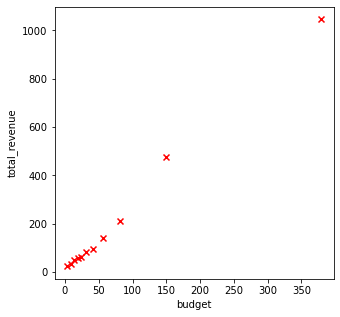

In [36]:
utils.plot_quantiles(budget_revenue_quantiles.budget, budget_revenue_quantiles.total_revenue)

In [37]:
# Release year 
utils.get_quantiles(train.release_year, train.total_revenue, ["year", "total_revenue"])

,quantile,year,total_revenue
0,0.0,1997.814672,121.780310
1,1.0,2001.530769,108.173347
2,2.0,2003.346154,109.415562
3,3.0,2004.907692,99.248298
4,4.0,2006.343629,104.220168
5,5.0,2007.707692,108.905429
6,6.0,2009.192308,126.152157
7,7.0,2010.473077,128.318325
8,8.0,2011.961538,158.838146
9,9.0,2013.594595,172.428132


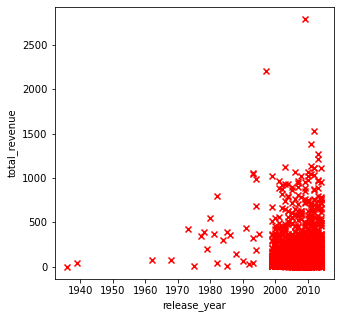

In [38]:
utils.plot_quantiles(train.release_year, train.total_revenue)

In [39]:
utils.get_quantiles(train.duration, train.total_revenue, ["duration", "total_revenue"])

,quantile,duration,total_revenue
0,0.0,0.000000,26.404084
1,1.0,41.388462,65.688356
2,2.0,89.230769,112.557113
3,3.0,94.784615,106.878207
4,4.0,99.471042,95.098314
5,5.0,104.376923,109.826526
6,6.0,109.511538,118.353131
7,7.0,115.938462,122.589909
8,8.0,124.373077,168.481786
9,9.0,144.563707,311.525148


In [40]:
# Genre 

utils.get_groups(train, 'genre'), utils.get_groups(test, 'genre') 

(              genre  count  mean_revenue  mean_budget
 0             Drama    657     67.826592    26.815378
 1            Comedy    498     73.629826    28.823845
 2         Adventure    381    280.834042    83.898950
 3            Action    318    209.625364    77.526456
 4          Thriller    289     96.967038    37.217531
 5            Horror    180     78.428245    22.104444
 6   Romantic Comedy    147     86.646231    30.009524
 7           Musical     40    152.222678    41.495675
 8       Dark Comedy     33     66.443387    26.862121
 9       Documentary     29     50.463167    11.865517
 10          Western     16     89.749959    57.500000
 11      Performance     10     41.475253     9.200000,
               genre  count  mean_revenue  mean_budget
 0             Drama    206     64.742557    22.364835
 1            Action    123    405.358817   105.050407
 2         Adventure    116    372.552237   102.393103
 3            Comedy    109     75.097716    26.419266
 4       

In [41]:
train.head()

,movie,budget,us_revenue,international_revenue,mpaa_rating,running_time,franchise,original_source,genre,production_method,type,production_companies,production_country,languages,distributor,release_year,total_revenue,mpaa_rating_clean,n_languages,languages2,is_franchise,n_original_source,original_source2,n_genre,genre2,n_production_method,production_method2,n_type,type2,n_production_companies,production_companies2,n_production_country,production_country2,n_distributor,distributor2,duration,na_duration,mpaa_rating_clean_R,mpaa_rating_clean_PG-13,mpaa_rating_clean_NotRated,mpaa_rating_clean_G,distributor2_Other,distributor2_WaltDisney,distributor2_20thCenturyFox,distributor2_ParamountPictures,distributor2_Lionsgate,distributor2_FoxSearchlight,distributor2_SonyPictures,distributor2_WarnerBros.,distributor2_Universal,original_source2_TV,original_source2_Other,original_source2_Remake,original_source2_FactualBook/Article,original_source2_Comic/GraphicNovel,original_source2_FictionBook/ShortStory,original_source2_OriginalScreenplay,original_source2_RealLifeEvents,genre2_Other,genre2_Drama,genre2_Thriller,genre2_RomanticComedy,genre2_Adventure,genre2_Action,genre2_Horror,genre2_Comedy,production_method2_Animation/LiveAction,production_method2_Other,production_method2_HandAnimation,production_method2_LiveAction,production_method2_DigitalAnimation,production_method2_Stop-MotionAnimation,type2_Fantasy,type2_ScienceFiction,type2_Other,type2_HistoricalFiction,type2_Dramatization,type2_KidsFiction,type2_Factual,type2_ContemporaryFiction,type2_SuperHero,production_companies2_MarvelStudios,production_companies2_UniversalPictures,production_companies2_Other,production_companies2_LakeshoreEntertainment,production_companies2_ColumbiaPictures,production_companies2_WorkingTitleFilms,production_companies2_WaltDisneyPictures,production_companies2_WarnerBros.,production_companies2_DreamWorksAnimation,production_companies2_WaltDisneyAnimationStudios,production_companies2_RevolutionStudios,production_country2_Canada,production_country2_UnitedStates,production_country2_Other,production_country2_France,production_country2_UnitedKingdom,production_country2_Germany,production_country2_Australia,languages2_Other,languages2_English,languages2_French,languages2_Spanish,languages2_Japanese
0,10th & Wolf,8.0,54.7,89.1,Not Rated,0,0,Real Life Events,Drama,Live Action,Dramatization,0,United States,English,ThinkFilm,2006,0.1438,Not Rated,3023.0,English,0,272.0,Real Life Events,863,Drama,3003.0,Live Action,341.0,Dramatization,0.0,Other,2652.0,United States,8.0,Other,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,A Guy Thing,20.0,15543.9,1886.7,"PG-13 for language, crude humor, some sexual c...",101 minutes,0,Original Screenplay,Romantic Comedy,Live Action,Contemporary Fiction,0,United States,English,MGM,2003,17.4306,PG-13,3023.0,English,0,1718.0,Original Screenplay,165,Romantic Comedy,3003.0,Live Action,1736.0,Contemporary Fiction,0.0,Other,2652.0,United States,74.0,Other,101,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,Abandon,25.0,10719.4,1500.0,"PG-13 for drug and alcohol content, sexuality,...",0,0,Original Screenplay,Thriller,Live Action,Contemporary Fiction,0,United States,English,Paramount Pictures,2002,12.2194,PG-13,3023.0,English,0,1718.0,Original Screenplay,392,Thriller,3003.0,Live Action,1736.0,Contemporary Fiction,0.0,Other,2652.0,United States,254.0,Paramount Pictures,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,Aimee & Jaguar,6.8,927.1,0.0,Not Rated,0,0,Fiction Book/Short Story,Drama,Live Action,Dramatization,0,United States,English,Zeitgeist,2000,0.9271,Not Rated,3023.0,English,0,637.0,Fiction Book/Short Story,863,Drama,3003.0,Live Action,341.0,Dramatization,0.0,Other,2652.0,

## Training the model

In [43]:
train[numeric].columns

Index(['budget', 'us_revenue', 'international_revenue', 'release_year',
       'total_revenue', 'is_franchise', 'duration', 'na_duration',
       'mpaa_rating_clean_R', 'mpaa_rating_clean_PG-13',
       'mpaa_rating_clean_NotRated', 'mpaa_rating_clean_G',
       'distributor2_Other', 'distributor2_WaltDisney',
       'distributor2_20thCenturyFox', 'distributor2_ParamountPictures',
       'distributor2_Lionsgate', 'distributor2_FoxSearchlight',
       'distributor2_SonyPictures', 'distributor2_WarnerBros.',
       'distributor2_Universal', 'original_source2_TV',
       'original_source2_Other', 'original_source2_Remake',
       'original_source2_FactualBook/Article',
       'original_source2_Comic/GraphicNovel',
       'original_source2_FictionBook/ShortStory',
       'original_source2_OriginalScreenplay',
       'original_source2_RealLifeEvents', 'genre2_Other', 'genre2_Drama',
       'genre2_Thriller', 'genre2_RomanticComedy', 'genre2_Adventure',
       'genre2_Action', 'genre2_Horror

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2598 entries, 0 to 3376
Columns: 104 entries, movie to languages2_Japanese
dtypes: float64(11), int32(3), int64(69), object(21)
memory usage: 2.1+ MB


In [45]:
numeric = [ col for col in numeric if col not in ['us_revenue', 'international_revenue', 'total_revenue']]

model = linear_model.LinearRegression()

# Train the model using the training sets
model.fit(train[numeric], train.total_revenue)

# The coefficients
coefs = pd.DataFrame({'variable': numeric, 'coefficient': model.coef_})


# Make predictions using the testing set
train.loc[:,'pred'] = model.predict(train[numeric])
test.loc[:,'pred'] = model.predict(test[numeric])

print("Train RMSE: " + str(utils.rmse(train.total_revenue, train.pred)))
print("Train top20%-bottom20% ratio: " + str(utils.tbr(train.total_revenue, train.pred)))

# Prediction and errors on the test set
print("Test RMSE: " + str(utils.rmse(test.total_revenue, test.pred)))
print("Test top20%-bottom20% ratio: " + str(utils.tbr(test.total_revenue, test.pred)))


Train RMSE: 122.42081104988293
Train top20%-bottom20% ratio: 13.860874561718834
Test RMSE: 186.40432886388376
Test top20%-bottom20% ratio: 24.01483881802532


C:\Users\nimblepants\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\nimblepants\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\nimblepants\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,variable,shap,sign,rel
0,languages2_Japanese,0.0824,-0.0824,1.0
1,release_year,0.0000,0.0000,0.0
2,production_companies2_LakeshoreEntertainment,0.0000,0.0000,0.0
3,production_companies2_Other,0.0000,0.0000,0.0
4,production_companies2_UniversalPictures,0.0000,0.0000,0.0
5,production_companies2_MarvelStudios,0.0000,0.0000,0.0
6,type2_SuperHero,0.0000,0.0000,0.0
7,type2_ContemporaryFiction,0.0000,0.0000,0.0
8,type2_Factual,0.0000,0.0000,0.0
9,type2_KidsFiction,0.0000,0.0000,0.0


In [53]:
# Variable coefficients
coefs.sort_values('coefficient')

,variable,coefficient
2,is_franchise,-3.735450e+12
8,mpaa_rating_clean_G,-6.908720e+11
5,mpaa_rating_clean_R,-6.908720e+11
7,mpaa_rating_clean_NotRated,-6.908720e+11
6,mpaa_rating_clean_PG-13,-6.908720e+11
37,production_method2_LiveAction,-6.591604e+11
35,production_method2_Other,-6.591604e+11
39,production_method2_Stop-MotionAnimation,-6.591604e+11
36,production_method2_HandAnimation,-6.591604e+11
38,production_method2_DigitalAnimation,-6.591604e+11


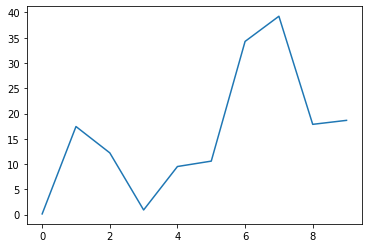

In [46]:
plt.plot(train.total_revenue[:10])


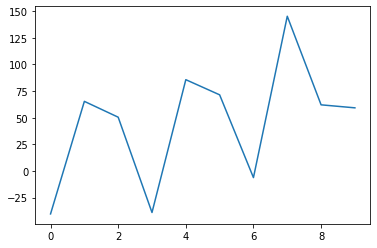

In [47]:
plt.plot(train.pred[:10])

In [55]:
# train gbm model

# read in data
dtrain = xgb.DMatrix(train[numeric].values, train['total_revenue'].values)

# specify parameters via map
param = {'max_depth':2, 'eta':0.05, 'objective':'reg:squarederror'}
num_round = 150
modelx = xgb.train(param, dtrain, num_round)

# make prediction
train['predx'] = modelx.predict(dtrain)
test['predx'] = modelx.predict(xgb.DMatrix(test[numeric].values))

print("Train RMSE: " + str(rmse(train.total_revenue, train.predx)))
print("Train top20%-bottom20% ratio: " + str(tbr(train.total_revenue, train.predx)))

# Prediction and errors on the test set
print("Test RMSE: " + str(rmse(test.total_revenue, test.predx)))
print("Test top20%-bottom20% ratio: " + str(tbr(test.total_revenue, test.predx)))


Train RMSE: 105.3694826863648
Train top20%-bottom20% ratio: 16.359642626954823
Test RMSE: 189.1484431373201
Test top20%-bottom20% ratio: 21.885640176295365


<ipython-input-55-8d0f407e3b82>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['predx'] = modelx.predict(dtrain)
<ipython-input-55-8d0f407e3b82>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predx'] = modelx.predict(xgb.DMatrix(test[numeric].values))
